In [15]:
import pyro
from abc import ABCMeta

import math
from tqdm import tqdm

from xenium_cluster import XeniumCluster

import torch
from pyro.infer.mcmc.mcmc_kernel import MCMCKernel


from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import PyroOptim
from pyro.optim import Adam
import pyro.distributions as dist
import pyro.distributions.transforms as T

from pyro.distributions.transforms import Spline, ComposeTransform
from pyro.distributions import TransformedDistribution


from data import prepare_DLPFC_data, prepare_synthetic_data, prepare_Xenium_data

# Potts Prior

The Potts prior is a prior distribution of cluster assignments given neighboring states. The general form of the Potts model is $$\pi(z_i) \propto \exp \left( \sum_i H(z_i) + \sum_{(i,j) \in G} J(z_i, z_j)\right)$$. H is the local potention representing some external influence of bias on the spot i. J is the interaction energy between neighboring sites. This represents the neighboring signals of spots, which is how we enforce the spatial clustering. The BayesSpace formulation feels like a more natural representation of this concept. $$\pi(z_i) \propto \exp \left( \frac{\gamma}{\langle ij \rangle} * 2\sum_{\langle ij \rangle} I(z_i = z_j)\right)$$ $\gamma$ is a smoothing parameter which can be tuned to increase the spatial contiguity of spatial assignments. 

In [16]:
class PottsPriorGibbs(MCMCKernel):
    
    def __init__(self, num_sites, num_clusters, neighbors, gamma):
        
        self.num_sites = num_sites
        self.num_clusters = num_clusters
        self.neighbors = neighbors
        self.gamma = gamma
        self.state = None

    def setup(self, initial_state):
        r"""
        Optional method to set up any state required at the start of the
        simulation run.

        :param int warmup_steps: Number of warmup iterations.
        :param \*args: Algorithm specific positional arguments.
        :param \*\*kwargs: Algorithm specific keyword arguments.
        """
        self.state = initial_state

    def cleanup(self):
        """
        Optional method to clean up any residual state on termination.
        """
        pass

    def logging(self):
        """
        Relevant logging information to be printed at regular intervals
        of the MCMC run. Returns `None` by default.

        :return: String containing the diagnostic summary. e.g. acceptance rate
        :rtype: string
        """
        return None

    def diagnostics(self):
        """
        Returns a dict of useful diagnostics after finishing sampling process.
        """
        # NB: should be not None for multiprocessing works
        return {}

    def end_warmup(self):
        """
        Optional method to tell kernel that warm-up phase has been finished.
        """
        pass

    @property
    def initial_params(self):
        """
        Returns a dict of initial params (by default, from the prior) to initiate the MCMC run.

        :return: dict of parameter values keyed by their name.
        """
        raise NotImplementedError

    @initial_params.setter
    def initial_params(self, params):
        """
        Sets the parameters to initiate the MCMC run. Note that the parameters must
        have unconstrained support.
        """
        raise NotImplementedError

    def sample(self, current_state):
        """
        Samples parameters from the posterior distribution, when given existing parameters.

        :param dict params: Current parameter values.
        :param int time_step: Current time step.
        :return: New parameters from the posterior distribution.
        """
        """Perform one Gibbs update over all sites."""
        new_state = current_state.clone()
        
        for i in range(self.num_sites):
            # Compute conditional probabilities for site i
            probs = torch.zeros(self.num_clusters)
            for k in range(self.num_clusters):
                # Compute the contribution of neighbors
                probs[k] = torch.sum(
                    torch.tensor([self.gamma if new_state[j] == k else 0.0 
                                  for j in self.neighbors[i]])
                )
            
            # Normalize to get valid probabilities
            probs = torch.exp(probs - torch.max(probs))  # Avoid numerical issues
            probs /= probs.sum()
            
            # Sample a new cluster label for site i
            new_state[i] = torch.multinomial(probs, 1).item()
        
        self.state = new_state
        return self.state

    def __call__(self, params):
        """
        Alias for MCMCKernel.sample() method.
        """
        return self.sample(params)


# Data Construction

We use the simulated dataset from the BayXenSmooth paper as an initial assessment of our idea. To make this happen we need to load in the data.

In [17]:
# Data Properties
batch_size = 16
num_clusters = 7
learn_global_variances = False

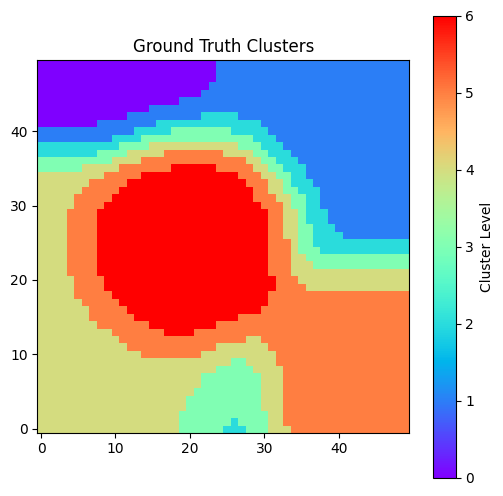

[-1.47257562  0.46511499  1.59663955  2.97219807 -4.86455653] [[1.78573878 0.         0.         0.         0.        ]
 [0.         0.73828492 0.         0.         0.        ]
 [0.         0.         2.46600644 0.         0.        ]
 [0.         0.         0.         2.11560433 0.        ]
 [0.         0.         0.         0.         1.40100295]]
[ 0.97765685 -3.07924327 -2.73748411 -3.45986822 -1.22186453] [[0.27988861 0.         0.         0.         0.        ]
 [0.         1.27818223 0.         0.         0.        ]
 [0.         0.         1.59619489 0.         0.        ]
 [0.         0.         0.         0.30553095 0.        ]
 [0.         0.         0.         0.         0.8604909 ]]
[-4.2965212   0.25761187  1.50289769  1.15472141  3.13869563] [[0.58891559 0.         0.         0.         0.        ]
 [0.         1.5454546  0.         0.         0.        ]
 [0.         0.         0.7570713  0.         0.        ]
 [0.         0.         0.         0.22191927 0.        ]


In [18]:
gene_data, spatial_locations, original_adata, prior_weights = prepare_synthetic_data(num_clusters=num_clusters)
prior_means = torch.zeros(num_clusters, gene_data.shape[1])
prior_scales = torch.ones(num_clusters, gene_data.shape[1])

In [19]:
data = torch.tensor(gene_data).float()

# Variational Inference

### Prior and Likelihood Calculations

In [20]:
torch.set_printoptions(sci_mode=False)
NUM_PARTICLES = 25

expected_total_param_dim = 2 # K x D

def model(data):

    with pyro.plate("clusters", num_clusters):

        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(prior_means, 10.0).to_event(1))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(prior_scales, 10.0).to_event(1))

    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        cluster_probs = pyro.sample("cluster_probs", dist.Dirichlet(torch.ones(num_clusters)), batch_size)
        # likelihood for batch
        if cluster_means.dim() == expected_total_param_dim:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(0).expand(batch_size, -1, -1), 
                    cluster_scales.unsqueeze(0).expand(batch_size, -1, -1), 
                    cluster_probs
                ), 
                obs=batch_data
            )
        # likelihood for batch WITH vectorization of particles
        else:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_scales.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_probs
                ), 
                obs=batch_data
            )

### Variational Guide

In [21]:
def normalizing_flow(K, batch_size):
    # Base distribution: standard normal for the entire batch and feature dimensions
    base_dist = dist.Normal(
        torch.zeros(batch_size, K-1),  # Batch size and feature dimensions
        torch.ones(batch_size, K-1)
    ).to_event(1)

    # Define transformations
    spline_transform = T.spline_coupling(K-1, count_bins=16)
    # planar_transform = T.Planar(K-1)
    stickbreak_transform = T.StickBreakingTransform()

    # Apply transforms for the batch
    flow_dist = dist.TransformedDistribution(base_dist, [spline_transform, stickbreak_transform])

    # Register learnable parameters for optimization
    pyro.module("spline_transform", spline_transform)

    return flow_dist

In [22]:
def guide(data):
    with pyro.plate("clusters", num_clusters):
        # Global variational parameters for cluster means and scales
        cluster_means_q_mean = pyro.param("cluster_means_q_mean", prior_means + torch.randn_like(prior_means) * 0.05)
        cluster_scales_q_mean = pyro.param("cluster_scales_q_mean", prior_scales + torch.randn_like(prior_scales) * 0.01, constraint=dist.constraints.positive)
        if learn_global_variances:
            cluster_means_q_scale = pyro.param("cluster_means_q_scale", torch.ones_like(prior_means) * 1.0, constraint=dist.constraints.positive)
            cluster_scales_q_scale = pyro.param("cluster_scales_q_scale", torch.ones_like(prior_scales) * 0.25, constraint=dist.constraints.positive)
            cluster_means = pyro.sample("cluster_means", dist.Normal(cluster_means_q_mean, cluster_means_q_scale).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q_mean, cluster_scales_q_scale).to_event(1))
        else:
            cluster_means = pyro.sample("cluster_means", dist.Delta(cluster_means_q_mean).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.Delta(cluster_scales_q_mean).to_event(1))

    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]

        # Cluster probabilities
        cluster_probs_flow_dist = normalizing_flow(num_clusters, batch_size)
        cluster_probs = pyro.sample("cluster_probs", cluster_probs_flow_dist)

        # You can now use `cluster_probs` for further operations like computing likelihoods


# Training the Model

In [23]:
pyro.clear_param_store()
NUM_EPOCHS = 1000
NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))

def per_param_callable(param_name):
    if param_name == 'cluster_means_q_mean':
        return {"lr": 0.01, "betas": (0.9, 0.999)}
    elif param_name == 'cluster_scales_q_mean':
        return {"lr": 0.01, "betas": (0.9, 0.999)}
    elif "logit" in param_name:
        return {"lr": 0.01, "betas": (0.9, 0.999)}
    else:
        return {"lr": 0.005, "betas": (0.9, 0.999)}

scheduler = Adam(per_param_callable)

# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=TraceMeanField_ELBO(num_particles=NUM_PARTICLES, vectorize_particles=True))

# Create a DataLoader for the data
# Convert data to CUDA tensors before creating the DataLoader
data = data.to('cuda')

# Clear the param store in case we're in a REPL
pyro.clear_param_store()

epoch_pbar = tqdm(range(NUM_EPOCHS))
cluster_means_trace = []
cluster_scales_trace = []
current_min_loss = float('inf')
PATIENCE = 15
patience_counter = 0
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_pbar.set_description(f"Epoch {epoch}")
    running_loss = 0.0
    for step in range(NUM_BATCHES):
        loss = svi.step(data)
        running_loss += loss / batch_size
        # running_loss += (loss + SPATIAL_PENALTY_WEIGHT * spatial_penalty()) / batch_size
    # svi.optim.step()
    if epoch % 1 == 0:
        print(f"Epoch {epoch} : loss = {round(running_loss, 4)}")

Epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyError: "ConditionedPlanar object expected to find key in intermediates cache but didn't"